In [44]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
# See model_gpu.ipynb, which fully converted the classification CNN to pytorch
# I had to code my own CNN using pytorch, this is modified code from model_gpu.ipynb
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6272, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #print("Output shape before flattening:", x.shape)
        if len(x.shape) == 4:  # Modify model to handle captum attribute method modifying tensor dimensions
            batch_size = x.shape[0]
            x = x.view(batch_size, -1)  # Flatten all but the first dimension
        else:
            x = torch.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

# Make the CNN use the GPU if possible
model = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = nn.DataParallel(model)
model.to(device)
model.load_state_dict(torch.load('model_gpu.pth', weights_only=True), strict=False)
model = model.eval()

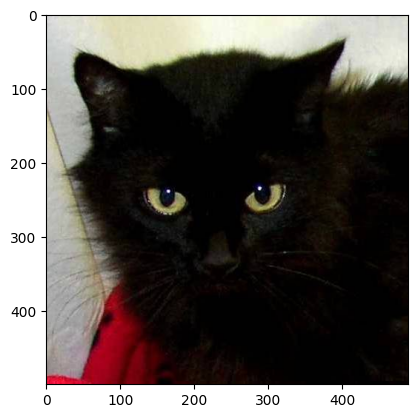

Predicted: 1.0


In [45]:
# Make sure model works
test_img = Image.open('dogscats/subset/test/cats/cat.1500.jpg')
plt.imshow(np.asarray(test_img))
plt.show()

transform = transforms.Compose([
    torchvision.transforms.Resize((150,150)),
    torchvision.transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_img = transform(test_img)
output = model(test_img).to(torch.float64).to(device)
print('Predicted:', output.item())


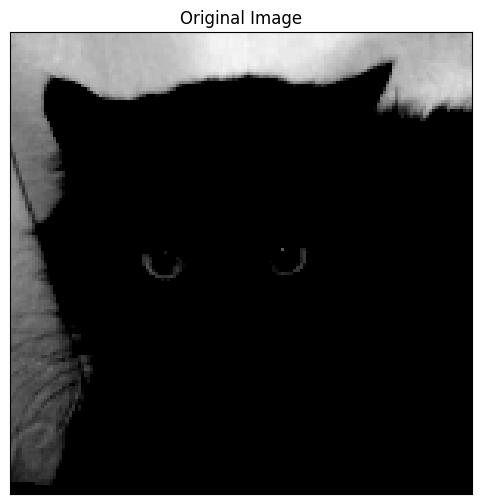

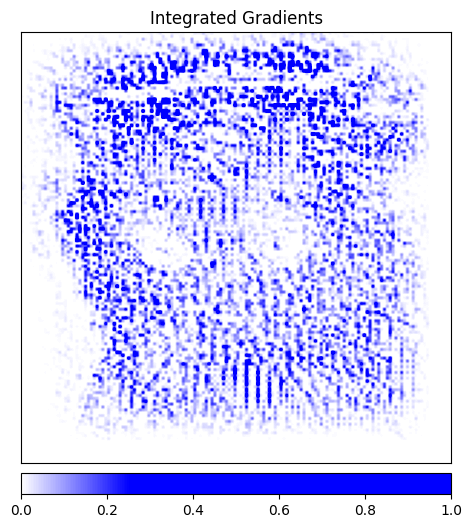

In [46]:
# Integrated Gradients
integrated_gradients = IntegratedGradients(model)
input_img = test_img.unsqueeze(0)
attributions_ig = integrated_gradients.attribute(input_img.to(device), n_steps=200)
_ = viz.visualize_image_attr(None, np.transpose(test_img.squeeze().cpu().detach().numpy(), (1, 2, 0)), method="original_image", title="Original Image")
default_cmap = LinearSegmentedColormap.from_list('custom blue', [(0, '#ffffff'),(0.25, '#0000ff'),(1, '#0000ff')], N=256)
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
np.transpose(test_img.squeeze().cpu().detach().numpy(), (1, 2, 0)), method='heat_map', cmap=default_cmap, show_colorbar=True,sign='positive',title='Integrated Gradients')

Integrated gradients figures out how important each feature is for determining the output. In the case of image classification, the features are pixels. It does this by creating empty baseline images that gradually get closer to the actual image, then integrating the difference created baseline images with respect to the actual image. You can image a path from an empty image to the complete image and seeing how the gradient changes as pixels are filled in, telling us which pixels are important. As we can see, the model pays heavy attention to only the cat.
$$
\phi_i^{IG}(f,x,x_i^{'})=(x_i-x_i^{'})*\int_{a=0}^1\frac{\partial f(x^{'}+\alpha(x-x^{'}))}{\partial x_i}d\alpha
$$

In [ ]:
layer_gradcam = LayerGradCam(model, model.module.conv4)
attributions_lgc = layer_gradcam.attribute(input_img.to(device))
upsame_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])
print(attributions_lgc.shape)
print(upsame_attr_lgc.shape)
print(input_img.shape)
#_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(), sign="all", title="Convolution layer")
_ = viz.visualize_image_attr_multiple(upsame_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
test_img.permute(1,2,0).numpy(), ["original_image", "blended_heat_map", "masked_image"], ["all", "positive", "positive"],
show_colorbar=True, titles=["Original", "Positive Attribution", "Masked"], fig_size=(18,6))

#upsamp_attr_lgc

torch.Size([1, 1, 15, 15])
torch.Size([1, 1, 150, 150])
torch.Size([1, 3, 150, 150])


Grad-CAM is similar to integrated gradients, however it attributes layers of the model or regions of the image to the output instead of individual pixels. It calculates the average gradient of the output with respect to the channels/feature maps of a layer.
$$
a_k^c = \frac{1}{z}\sum_i\sum_j\frac{\partial y^c}{\partial A_{ij}^k}
$$